<a href="https://colab.research.google.com/github/vidhipatani/Lab0-PySpark/blob/main/ALY6110_MOD5_AssignVPatani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# 1. Prepare your Google Colab PySpark Session:

# Install PySpark in Google Colab
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("BostonHousingPCA").getOrCreate()

In [6]:
# 2. Read 'BostonHousing.csv' dataset in PySpark:

# Load the dataset
bh_data = spark.read.csv("BostonHousing.csv", header=True, inferSchema=True)
bh_data.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [7]:
#3.  Combine features into a single vector column
feature_columns = [col for col in bh_data.columns if col != 'medv']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(bh_data)

In [8]:
#4. Standardize features for principal component analysis python

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

In [9]:
#5. Train model for two principal component analysis python

# Perform PCA with two principal components
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)
pca_data = pca_model.transform(scaled_data)


In [10]:
#6. Collect distributed data in numpy array and then convert to pandas dataframepython

# Collect the PCA results into a Pandas DataFrame
pca_features = np.array(pca_data.select("pca_features").rdd.map(lambda row: row[0]).collect())
pca_df = pd.DataFrame(pca_features, columns=["PC1", "PC2"])

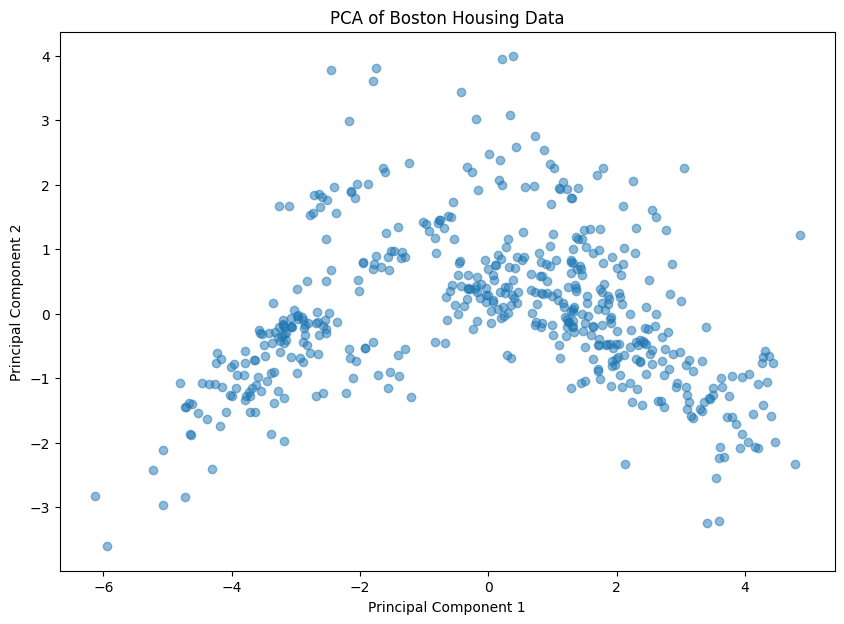

In [11]:
#7. Plot two principal components python

# Plot the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.5)
plt.title("PCA of Boston Housing Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [12]:
#8. Vectorize features and target together for model development python

# Prepare the final dataset for regression
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = vector_assembler.transform(bh_data).select("features", "medv")

In [13]:
#9. Split dataset into training and testing datasets python

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

In [14]:
#10. Fit model for linear regression python

# Fit a linear regression model
lr = LinearRegression(featuresCol="features", labelCol="medv")
lr_model = lr.fit(train_data)

In [15]:
#11. Find out model coefficients and intercept python

# Get model coefficients and intercept
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [-0.11928695491963032,0.047265467802461984,0.04861097089138011,2.939575117427635,-16.52464044013388,4.450208055969092,-0.006468585398541153,-1.35869582373556,0.27409583913770746,-0.01484124492366279,-0.8649017257130034,0.007797138613616727,-0.42011398849468246]
Intercept: 30.34464410949584


In [16]:
#12. Evaluate model for test dataset python

# Evaluate the model on the test data
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data:", rmse)

Root Mean Squared Error (RMSE) on test data: 5.795278736539407


+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.01096,55.0,2.2...|22.0|27.415548111956568|
|[0.01381,80.0,0.4...|50.0|41.020541639500735|
|[0.01439,60.0,2.9...|29.1|31.457706876788876|
|[0.01501,80.0,2.0...|24.5|27.800872027630003|
|[0.01778,95.0,1.4...|32.9| 30.78816002482084|
+--------------------+----+------------------+
only showing top 5 rows



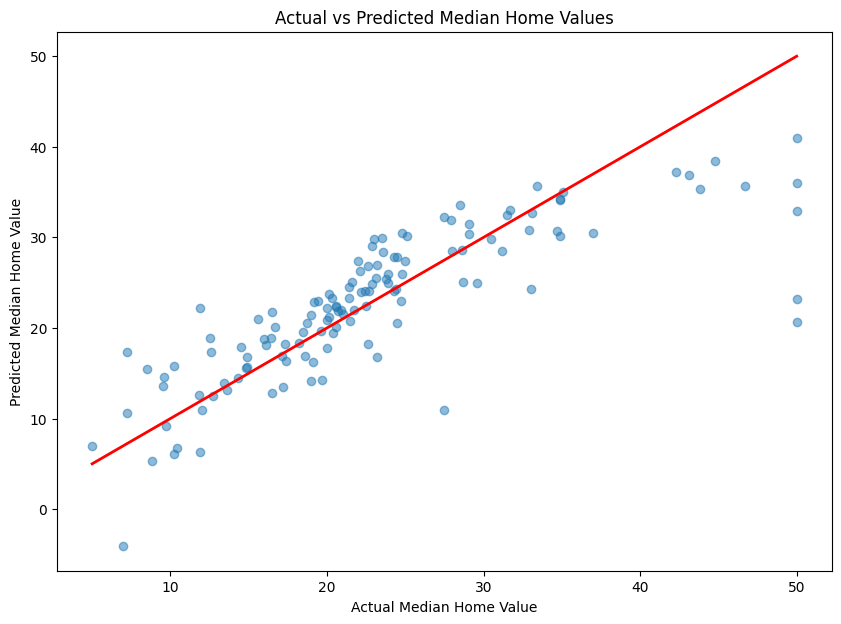

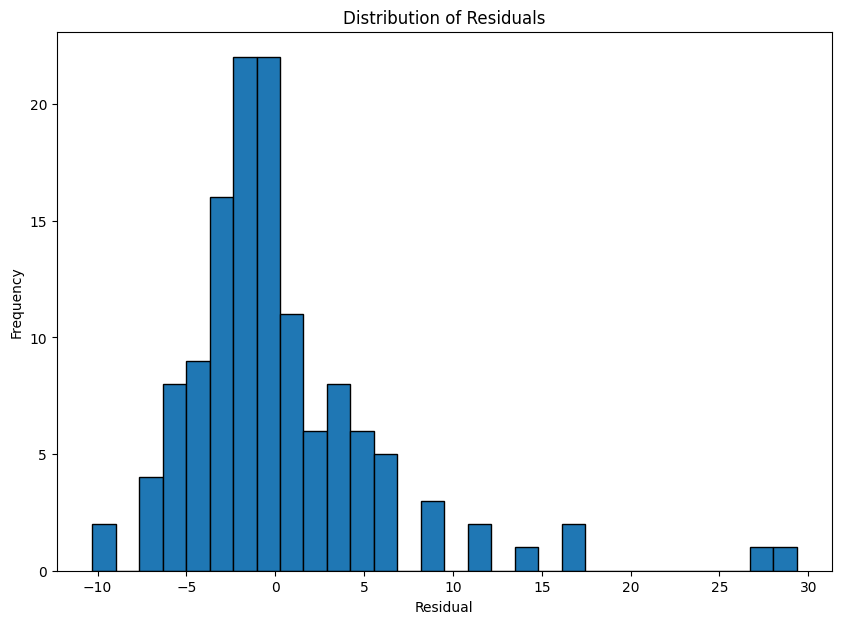

In [17]:
#13. Perform further analysis for better interpretation of model results python

# Show sample predictions
predictions.select("features", "medv", "prediction").show(5)

# Residual analysis
predictions_df = predictions.toPandas()
plt.figure(figsize=(10, 7))
plt.scatter(predictions_df["medv"], predictions_df["prediction"], alpha=0.5)
plt.plot([predictions_df["medv"].min(), predictions_df["medv"].max()],
         [predictions_df["medv"].min(), predictions_df["medv"].max()],
         color='red', linewidth=2)
plt.title("Actual vs Predicted Median Home Values")
plt.xlabel("Actual Median Home Value")
plt.ylabel("Predicted Median Home Value")
plt.show()

# Distribution of residuals
residuals = predictions_df["medv"] - predictions_df["prediction"]
plt.figure(figsize=(10, 7))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()